# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import seaborn as sns
sns.set_theme()

from datetime import date

from new_API_MCForecastTools import MCSimulation

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
#crypto_portfolio = pd.DataFrame.from_dict({'BTC':[1.2], 'ETH':[5.3]})
#stock_portfolio = pd.DataFrame.from_dict({'SPY':[50], 'AGG':[200]})
my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [5]:
# Fetch current BTC price
btc_price = requests.get(btc_url).json()['data']['1']['quotes']['USD']['price']

# Fetch current ETH price
eth_price = requests.get(eth_url).json()['data']['1027']['quotes']['USD']['price']

# Compute current value of my crpto
my_btc_value = btc_price * my_btc
my_eth_value = eth_price * my_eth

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $50680.80
The current value of your 5.3 ETH is $15666.16


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [7]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [8]:
# Format current date as ISO format
current_date = pd.Timestamp("2020-05-01", tz="America/New_York").isoformat()
start_date = pd.Timestamp("2020-05-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-05-01", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D'
timeframe = "1Day"

start = '2022-03-18'
end = '2022-03-18'
# Retrieve daily bars for SPY, TSLA, and AAPL in a DataFrame
ticker_data = alpaca.get_bars(tickers, timeframe, start, end).df

df_ticker = pd.pivot_table(ticker_data, values=['close'], columns='symbol', index =ticker_data.index)

# Preview DataFrame
df_ticker.head()

close        
symbol                       AGG     SPY
timestamp                               
2022-03-18 04:00:00+00:00  108.1  444.52

In [9]:
# Pick AGG and SPY close prices
agg_close_price = df_ticker['close']['AGG'][-1]
spy_close_price = df_ticker['close']['SPY'][-1]

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $108.1
Current SPY closing price: $444.52


In [10]:
# Compute the current value of shares
my_agg_value = agg_close_price * my_agg
my_spy_value = spy_close_price * my_spy

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $22226.00
The current value of your 200 AGG shares is $21620.00


### Savings Health Analysis

In [11]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
crypto_amount = my_btc_value + my_eth_value
shares_amount = my_agg_value + my_spy_value

# Create savings DataFrame
df_savings = pd.DataFrame({'amount':[crypto_amount, shares_amount]},index=['crypto', 'shares'])

# Display savings DataFrame
display(df_savings)

,amount
crypto,66346.964
shares,43846.000


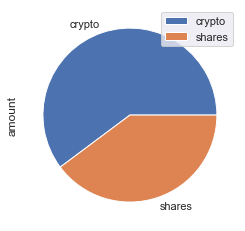

In [12]:
# Plot savings pie chart
share_pie = df_savings.plot.pie(y='amount')

In [13]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = df_savings['amount'].sum()

# Validate saving health
if total_savings > emergency_fund:
    print('Congratulations! You have enough money in your emergency fund.')
elif total_savings == emergency_fund:
    print('Congratulations! You are reaching this financial goal.')
else:
    print('You should save more. Try to avoid buying latte.')
    

Congratulations! You have enough money in your emergency fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [14]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
#start_date = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat()
#end_date = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()
start_date = '2016-05-01'
end_date = '2021-05-01'

In [15]:
# Get 5 years' worth of historical data for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
df_stock_data = alpaca.get_bars(tickers, timeframe, start_date, end_date).df

df_ticker = pd.pivot_table(df_stock_data, values=['close'], columns='symbol', index=df_stock_data.index)

# Preview DataFrame
df_ticker.head()

close          
symbol                         AGG       SPY
timestamp                                   
2016-05-02 04:00:00+00:00  110.605  207.9700
2016-05-03 04:00:00+00:00  110.810  206.1592
2016-05-04 04:00:00+00:00  110.860  205.0100
2016-05-05 04:00:00+00:00  111.140  204.9700
2016-05-06 04:00:00+00:00  110.970  205.7200

In [16]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
num_years = 30
num_trading_days = 252


MC_dist = MCSimulation(
    portfolio_data = df_ticker,
    weights = [.60,.40],
    num_simulation = 500,
    num_trading_days = num_trading_days * num_years
)

In [17]:
# Printing the simulation input data
MC_dist.portfolio_data

close           daily_return          
symbol                        AGG       SPY          AGG       SPY
timestamp                                                         
2016-05-03 04:00:00+00:00  110.81  206.1592     0.001853 -0.008707
2016-05-04 04:00:00+00:00  110.86  205.0100     0.000451 -0.005574
2016-05-05 04:00:00+00:00  111.14  204.9700     0.002526 -0.000195
2016-05-06 04:00:00+00:00  110.97  205.7200    -0.001530  0.003659
2016-05-09 04:00:00+00:00  111.04  205.8892     0.000631  0.000822
...                           ...       ...          ...       ...
2021-04-26 04:00:00+00:00  114.65  417.6100    -0.000871  0.002088
2021-04-27 04:00:00+00:00  114.37  417.5200    -0.002442 -0.000216
2021-04-28 04:00:00+00:00  114.43  417.4000     0.000525 -0.000287
2021-04-29 04:00:00+00:00  114.37  420.0600    -0.000524  0.006373
2021-04-30 04:00:00+00:00  114.49  417.3000     0.001049 -0.006570

[1258 rows x 4 columns]

In [18]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_dist.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/alba/Documents/FinTech/python-homework/05-APIs/new_API_MCForecastTools.py:133: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000838,1.002837,0.998790,1.001367,1.003217,1.004705,1.000923,1.000890,1.003562,1.003837,...,1.004148,1.002610,0.996919,1.004323,0.995497,0.991331,0.996305,1.000776,0.997257,0.997191
2,1.002567,0.999254,0.998362,1.004345,1.012714,1.002630,0.998798,1.006992,0.999803,1.007435,...,0.998650,1.012032,0.993236,1.010968,1.002013,0.989316,0.995063,0.993902,1.005474,0.994608
3,0.999478,1.004410,0.995857,1.004551,1.017690,0.998916,1.009806,1.004684,0.997843,0.999210,...,0.998318,1.012088,0.993816,1.004407,0.997298,0.986756,0.998295,0.986078,1.006634,0.985509
4,1.004035,0.996099,1.002454,1.006629,1.023291,0.996184,1.013575,1.009290,1.004126,0.999107,...,1.001532,1.009201,0.997631,0.998326,1.002398,0.983165,1.004435,0.988549,1.004531,0.991740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,5.823386,4.723818,8.913208,10.481515,5.828849,7.072532,6.047485,4.689652,3.555007,3.312115,...,10.744819,4.209855,3.629849,6.322555,6.607696,12.340110,5.167541,4.915484,6.415852,6.550298
7557,5.879350,4.733844,8.927723,10.506316,5.869141,7.087063,6.016182,4.685875,3.548637,3.303468,...,10.774942,4.221448,3.638949,6.359808,6.571775,12.384717,5.148010,4.899608,6.425893,6.521388
7558,5.905951,4.722528,8.885896,10.499528,5.879465,7.065323,5.970435,4.692668,3.554252,3.297056,...,10.664943,4.243091,3.621352,6.369267,6.571696,12.372714,5.103173,4.870198,6.444025,6.478885
7559,5.929962,4.716504,8.853356,10.539094,5.888446,7.082570,5.951648,4.744593,3.565334,3.283563,...,10.707930,4.218845,3.653556,6.336491,6.509583,12.397431,5.081790,4.864308,6.426463,6.543973


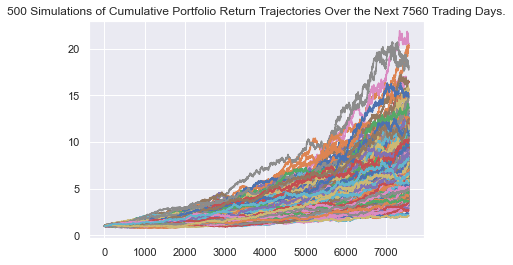

In [19]:
# Plot simulation outcomes
line_plot = MC_dist.plot_simulation()

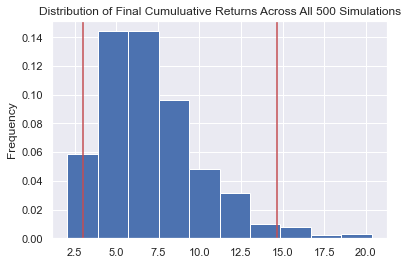

In [20]:
# Plot probability distribution and confidence intervals
dist_plot = MC_dist.plot_distribution()

### Retirement Analysis

In [21]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_dist.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           500.000000
mean              7.138318
std               3.014737
min               2.061824
25%               4.999398
50%               6.746046
75%               8.719549
max              20.370239
95% CI Lower      3.015857
95% CI Upper     14.670406
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [22]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000

ci_lower = round(tbl[8]*initial_investment,2)
ci_upper = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $60317.14 and $293408.12


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [23]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(tbl[8]*initial_investment,2)
ci_upper = round(tbl[9]*initial_investment,2)


# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $90475.71 and $440112.18


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [24]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
early_retirement = 5

MC_dist_five = MCSimulation(
    portfolio_data = df_ticker,
    weights = [.20,.80],
    num_simulation = 500,
    num_trading_days = num_trading_days * early_retirement
)

In [25]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_dist_five.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/alba/Documents/FinTech/python-homework/05-APIs/new_API_MCForecastTools.py:133: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.009647,0.992908,1.003888,0.998536,1.011647,1.002832,1.001782,1.012500,1.010639,0.976908,...,0.992679,1.011314,0.995162,0.992507,0.986988,1.001142,0.998985,1.009139,0.998093,1.000586
2,1.014073,0.995767,1.015568,0.987573,1.020782,1.002945,0.995555,0.988986,1.013783,0.987722,...,0.991816,1.014620,0.995842,0.993173,0.986536,1.010104,1.015905,1.007432,1.009694,1.017570
3,1.009119,0.991392,1.015262,0.989250,1.013409,1.013620,0.998192,0.979392,1.011861,0.980895,...,0.972932,1.021742,1.011555,1.009138,0.981879,1.013351,1.016008,1.018495,1.014092,0.998193
4,1.003402,0.993882,1.007506,0.981881,1.029850,1.015138,0.994481,0.999319,1.016016,0.965789,...,0.979624,1.016974,1.026167,1.011726,0.978429,1.026976,1.015068,1.018240,1.015086,1.001120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.158047,2.032203,2.657421,1.628039,1.433389,1.534991,1.360840,2.797694,2.487535,1.272810,...,4.347779,1.405609,1.330211,1.367467,2.051095,2.687038,1.724749,1.564757,1.637370,2.574940
1257,1.142536,2.035313,2.688011,1.610587,1.449021,1.544974,1.366555,2.781846,2.510167,1.259091,...,4.312038,1.397868,1.320627,1.366900,2.082573,2.664997,1.724102,1.563771,1.621651,2.590726
1258,1.144457,2.003851,2.650384,1.616795,1.459525,1.524109,1.369056,2.819848,2.545025,1.253167,...,4.304727,1.391897,1.328333,1.355471,2.055150,2.696553,1.711946,1.553460,1.593943,2.598340
1259,1.148172,1.998737,2.656818,1.612461,1.482483,1.548959,1.368040,2.837443,2.555922,1.273149,...,4.311263,1.387783,1.323585,1.370819,2.036827,2.694240,1.692488,1.564489,1.602786,2.602687


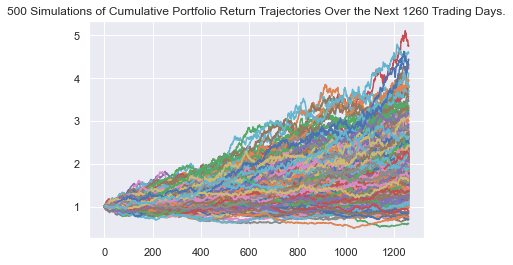

In [26]:
# Plot simulation outcomes
line_plot_five = MC_dist_five.plot_simulation()

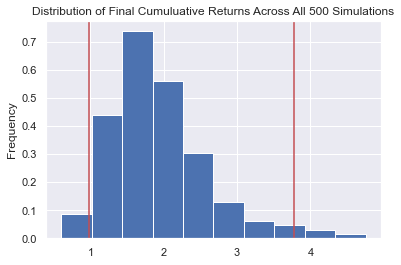

In [27]:
# Plot probability distribution and confidence intervals
dist_plot_early = MC_dist_five.plot_distribution()

In [28]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_five = MC_dist_five.summarize_cumulative_return()

# Print summary statistics
print(tbl_five)

count           500.000000
mean              1.924787
std               0.674806
min               0.602305
25%               1.483692
50%               1.809132
75%               2.243332
max               4.753507
95% CI Lower      0.974644
95% CI Upper      3.779145
Name: 1260, dtype: float64


In [29]:
# Set initial investment
initial_investment_five = 200000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(tbl_five[8]*initial_investment_five,2)
ci_upper_five = round(tbl_five[9]*initial_investment_five,2)


# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_five} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $200000 in the portfolio over the next 5 years will end within in the range of $194928.71 and $755828.96


### Ten Years Retirement Option

In [30]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
moderate_retirement = 10

MC_dist_ten = MCSimulation(
    portfolio_data = df_ticker,
    weights = [.05,.95],
    num_simulation = 500,
    num_trading_days = num_trading_days * moderate_retirement
)

In [31]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_dist_ten.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/alba/Documents/FinTech/python-homework/05-APIs/new_API_MCForecastTools.py:133: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001487,0.995105,1.001655,1.004112,1.003569,0.991990,1.007459,0.992292,1.007635,0.995543,...,1.007354,0.992866,1.014248,1.017073,1.002123,1.002042,1.005657,0.991165,1.003151,0.999194
2,0.996599,1.005812,0.998535,0.998021,1.011523,0.987690,1.008915,0.968929,1.014629,1.010258,...,0.995896,0.999709,1.002021,1.014377,0.997936,1.006209,1.008484,0.980491,1.010321,1.009325
3,0.999747,1.008909,0.982018,1.007169,1.014465,0.986049,0.998551,0.962442,1.006388,1.013755,...,0.996089,1.028138,1.007826,0.990099,0.995504,1.005868,0.995198,0.981181,1.018847,1.024757
4,1.009552,1.004961,0.983105,1.005242,1.031375,0.972493,1.001555,0.959305,0.989625,1.009791,...,0.988738,1.037125,1.009506,1.002262,1.001328,1.008057,0.995574,0.976369,1.007836,1.021739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,6.062748,3.054376,2.843969,3.812839,2.238067,2.469204,4.159342,3.171893,4.263248,5.393073,...,2.650773,5.204680,6.786990,2.799973,14.342386,1.784994,1.884218,1.722660,2.913744,4.696268
2517,6.099069,3.075578,2.777652,3.840376,2.225247,2.460966,4.096880,3.191970,4.271610,5.347848,...,2.678695,5.196026,6.730559,2.816705,14.272804,1.794183,1.845913,1.738518,2.930510,4.737379
2518,6.119798,3.092882,2.787556,3.834309,2.200021,2.447817,4.120401,3.179106,4.224054,5.418350,...,2.712602,5.250867,6.749677,2.822861,14.136111,1.741526,1.873205,1.731334,2.925708,4.711344
2519,6.133304,3.140191,2.738095,3.861691,2.172266,2.435924,4.096232,3.203618,4.227011,5.348748,...,2.741907,5.257170,6.850696,2.824651,14.238424,1.754765,1.923104,1.692089,2.896399,4.642103


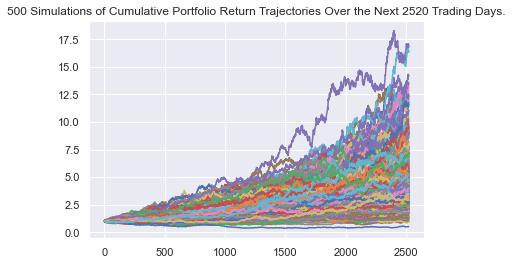

In [32]:
# Plot simulation outcomes
line_plot_ten = MC_dist_ten.plot_simulation()

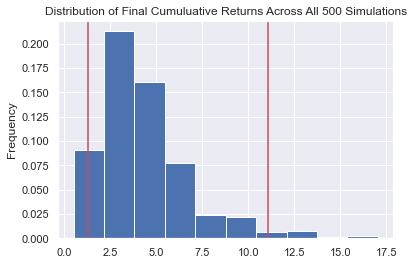

In [33]:
# Plot probability distribution and confidence intervals
dist_plot_ten = MC_dist_ten.plot_distribution()

In [34]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_ten = MC_dist_ten.summarize_cumulative_return()

# Print summary statistics
print(tbl_ten)

count           500.000000
mean              4.315714
std               2.408166
min               0.512409
25%               2.681639
50%               3.808241
75%               5.325147
max              17.046066
95% CI Lower      1.285438
95% CI Upper     11.062074
Name: 2520, dtype: float64


In [35]:
# Set initial investment
initial_investment_ten = 50000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(tbl_ten[8]*initial_investment_ten,2)
ci_upper_ten = round(tbl_ten[9]*initial_investment_ten,2)



# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_ten} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $50000 in the portfolio over the next 10 years will end within in the range of $64271.89 and $553103.72


# Conclusion
I made two plans 5-year and 10-year plans. They give approximately the same return as a 30-year long plan. The main difference between plans is: the 5-year plan is riskier and requires a large initial investment and is riskier than the 30-year plan. A 10-year plan requires a moderate initial investment but it is very risky.